# Classification
## Motivating example
A telecom company wants to anticipate a current customer's decision to end their contract and turn to a competitor's services. This would allow for proactivate measures such as targeted ads and promotions to increase the probability that that customer is retained.

This is an example of a binary classification problem, whereby each data point is assigned one of two possible discrete classes. In our case, the customer base is split base on whether or not they are predicted to churn in the near future.

In [230]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import OneHotEncoder

## Data Preparation

In [205]:
df = pd.read_csv('data.csv')

In [206]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [207]:
# standardize column names
df.columns = map(lambda x: x.lower().replace(" ", "_"), df.columns)

In [208]:
str_cols = df.dtypes[df.dtypes == 'object'].index

for col in str_cols:
	df[col] = df[col].str.lower().str.replace(" ", "_")

In [209]:
# convert and impute total charges
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce').fillna(0)

In [210]:
df.churn = (df.churn == 'yes').astype(int)

In [211]:
df.drop('customerid', axis=1, inplace=True)

## Validation Framework

In [212]:
def data_split(df, test_size, val_size, random_state=42):
	df, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
	df_train, df_val = train_test_split(df, test_size=val_size/(1-test_size), random_state=random_state)

	return df_train, df_val, df_test

In [213]:
df_train, df_val, df_test = data_split(df, test_size=.2, val_size=.2, random_state=1)

In [214]:
assert df_val.shape == df_test.shape

In [215]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [216]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

df_train.drop('churn', axis=1, inplace=True)
df_val.drop('churn', axis=1, inplace=True)
df_test.drop('churn', axis=1, inplace=True)

## EDA

In [217]:
# target variable distribution
100 * df.churn.value_counts(normalize=True)

churn
0    73.463013
1    26.536987
Name: proportion, dtype: float64

In [218]:
global_churn_rate = df.churn.mean()

In [219]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = list(set(df.columns).difference(set(numerical)))

In [220]:
df[categorical].nunique()

streamingmovies     3
churn               2
seniorcitizen       2
streamingtv         3
dependents          2
contract            3
paperlessbilling    2
partner             2
gender              2
deviceprotection    3
internetservice     3
onlinesecurity      3
onlinebackup        3
techsupport         3
phoneservice        2
paymentmethod       4
multiplelines       3
dtype: int64

### Feature Importance
#### Churn Rate & Risk Ratio

In [221]:
# churn rate by gender
gender_churn = df.groupby(['gender'], as_index=False).churn.mean()
gender_churn['diff'] = global_churn_rate - gender_churn.churn
gender_churn['risk_ratio'] = gender_churn.churn / global_churn_rate
gender_churn

,gender,churn,diff,risk_ratio
0,female,0.269209,-0.003839,1.014466
1,male,0.261603,0.003766,0.985807


In [222]:
# churn rate by relationship status
partner_churn = df.groupby(['partner'], as_index=False).churn.mean()
partner_churn['diff'] = global_churn_rate - partner_churn.churn
partner_churn['risk_ratio'] = partner_churn.churn / global_churn_rate
partner_churn

,partner,churn,diff,risk_ratio
0,no,0.329580,-0.064210,1.241964
1,yes,0.196649,0.068721,0.741038


In [223]:
for c in categorical:
	print(c.upper())
	group_churn = df.groupby(c, as_index=False).churn.mean()
	group_churn['diff'] = global_churn_rate - group_churn.churn
	group_churn['risk_ratio'] = group_churn.churn / global_churn_rate
	print(group_churn)
	print("\n===================================================\n")

STREAMINGMOVIES
       streamingmovies     churn      diff  risk_ratio
0                   no  0.336804 -0.071434    1.269188
1  no_internet_service  0.074050  0.191320    0.279044
2                  yes  0.299414 -0.034044    1.128291


CHURN
   churn     diff  risk_ratio
0    0.0  0.26537    0.000000
1    1.0 -0.73463    3.768325


SENIORCITIZEN
   seniorcitizen     churn      diff  risk_ratio
0              0  0.236062  0.029308    0.889557
1              1  0.416813 -0.151443    1.570686


STREAMINGTV
           streamingtv     churn      diff  risk_ratio
0                   no  0.335231 -0.069861    1.263261
1  no_internet_service  0.074050  0.191320    0.279044
2                  yes  0.300702 -0.035332    1.133143


DEPENDENTS
  dependents     churn      diff  risk_ratio
0         no  0.312791 -0.047422    1.178700
1        yes  0.154502  0.110868    0.582215


CONTRACT
         contract     churn      diff  risk_ratio
0  month-to-month  0.427097 -0.161727    1.609440
1        o

#### Mutual Information

In [224]:
def mutual_info_churn_score(series):
	return mutual_info_score(series, df.churn)

In [225]:
df_mutual_info = df[categorical].drop('churn', axis=1).apply(mutual_info_churn_score)
df_mutual_info.sort_values(inplace=True)

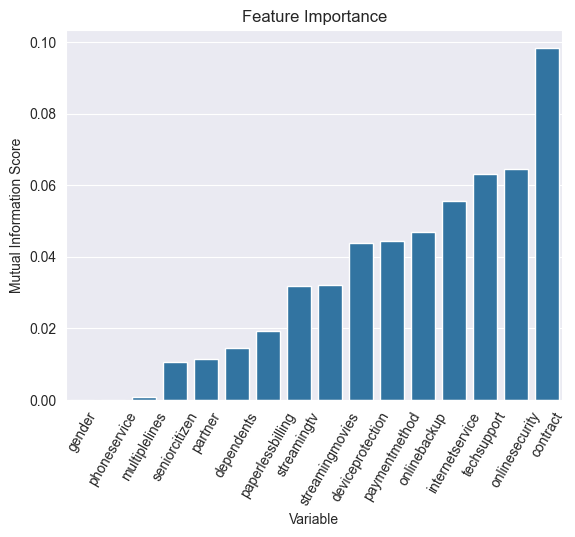

In [226]:
sns.barplot(x=df_mutual_info.index, y=df_mutual_info.values)
plt.xticks(rotation=60)
plt.title("Feature Importance")
plt.xlabel('Variable')
plt.ylabel('Mutual Information Score')
plt.show()

#### Correlation

In [227]:
df_corr = df[numerical].corrwith(df.churn)
df_corr.sort_values(inplace=True)

In [228]:
df_corr

tenure           -0.352229
totalcharges     -0.198324
monthlycharges    0.193356
dtype: float64

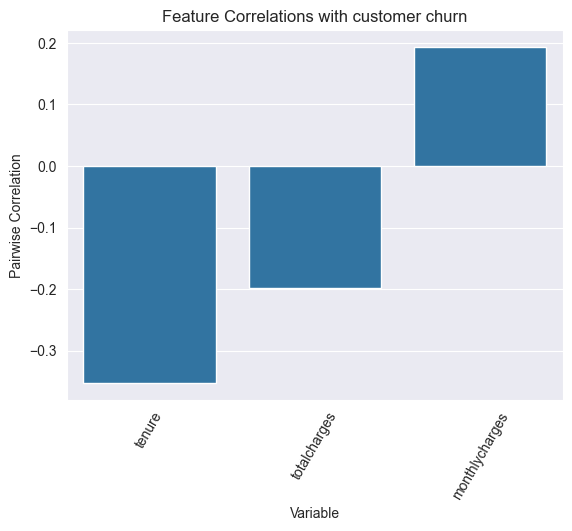

In [229]:
sns.barplot(x=df_corr.index, y=df_corr.values)
plt.xticks(rotation=60)
plt.title("Feature Correlations with customer churn")
plt.xlabel('Variable')
plt.ylabel('Pairwise Correlation')
plt.show()